In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
set_config(working_memory=1024)

In [2]:
data = pd.read_csv('tlacuachitos_vip_customers_data.csv')
data.head()

,CustomerID,Age,Income,Tenure,Education,Industry,Geographic Location,Churn_Risk,Cohort
0,1,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31
1,2,69,55297.364348,6,Bachelor,Technology,South America,0,2021-08-31
2,3,46,57978.753383,3,Bachelor,Finance,Europe,1,2019-05-31
3,4,32,60445.266900,3,High School,Education,South America,1,2021-02-28
4,5,60,57741.870929,5,Bachelor,Entertainment,Asia,0,2018-10-31


In [3]:
df_transactions = pd.read_csv('tlacuachitos_vip_transactions.csv')
df_transactions.head()

,CustomerID,TransactionDate,TransactionAmount
0,1,2023-10-31,518.444092
1,1,2024-07-31,353.796197
2,1,2024-01-31,38.206591
3,1,2024-06-30,724.929423
4,2,2022-02-28,145.616000


In [4]:
# Separar variables numéricas y categóricas
numerical_features = ['Age', 'Income', 'Tenure']
categorical_features = ['Education', 'Industry', 'Geographic Location']

# Hacer las categóricas dummies
encoded_features = pd.get_dummies(data[categorical_features], 
               columns=categorical_features, 
               drop_first=True)

# Estandarizar variables numéricas
data_to_model_standarized = StandardScaler().fit_transform(data[numerical_features])

# Hacer dataframe variables numéricas
data_to_model_df = pd.DataFrame(data_to_model_standarized, 
                                columns=numerical_features).reset_index()

# Acomodar variables categóricas
encoded_features_df = encoded_features.reset_index()

# Juntar ambas variables
data_to_model = data_to_model_df.merge(encoded_features_df, on='index')
data_to_model = data_to_model.drop('index', axis=1)

In [5]:
# Dar más peso a ciertas variables para la agrupación
#data_to_model['Income'] = data_to_model['Income'] * 1.2
data_to_model

,Age,Income,Tenure,Education_High School,Education_Master,Education_PhD,Industry_Entertainment,Industry_Finance,Industry_Healthcare,Industry_Technology,Geographic Location_Australia,Geographic Location_Europe,Geographic Location_North America,Geographic Location_South America
0,0.824019,0.121621,-0.878889,False,True,False,False,False,False,True,False,True,False,False
1,1.688471,0.286515,0.451668,False,False,False,False,False,False,True,False,False,False,True
2,0.159056,0.460267,-0.878889,False,False,False,False,True,False,False,False,True,False,False
3,-0.771892,0.620095,-0.878889,True,False,False,False,False,False,False,False,False,False,True
4,1.090004,0.444917,0.008149,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,-1.170870,-0.365427,1.338705,False,False,False,False,False,False,False,False,True,False,False
1139,0.491537,-0.713290,1.782224,False,False,False,False,False,False,False,False,False,False,False
1140,-0.971381,0.399656,0.008149,True,False,False,False,True,False,False,False,False,True,False
1141,0.558034,-1.035115,0.451668,False,False,False,False,False,True,False,False,False,True,False


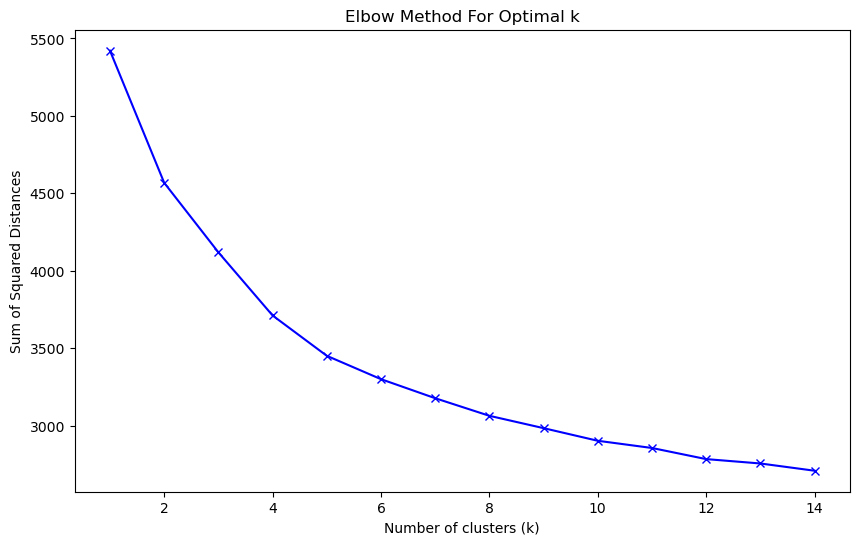

In [6]:
# Determinar el número óptimo de clusters usando el método del codo
sum_of_squared_distances = []
K = range(1, 15)  # Ajuste el rango según sea necesario
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(data_to_model)
    sum_of_squared_distances.append(km.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [7]:
# Aplicar K-means clustering para identificar segmentos de clientes
kmeans = KMeans(n_clusters=5, random_state=42) 
labels = kmeans.fit_predict(data_to_model)

# Agregar las etiquetas del cluster al DataFrame original para análisis
data_to_model['Cluster'] = labels
data['Cluster'] = labels
data.head()

,CustomerID,Age,Income,Tenure,Education,Industry,Geographic Location,Churn_Risk,Cohort,Cluster
0,1,56,52752.677346,3,Master,Technology,Europe,1,2023-08-31,4
1,2,69,55297.364348,6,Bachelor,Technology,South America,0,2021-08-31,4
2,3,46,57978.753383,3,Bachelor,Finance,Europe,1,2019-05-31,4
3,4,32,60445.266900,3,High School,Education,South America,1,2021-02-28,0
4,5,60,57741.870929,5,Bachelor,Entertainment,Asia,0,2018-10-31,4


In [8]:
def boxplot_clusters(columns):
    for col in columns:
        plt.figure(figsize=(5, 5))
        sns.boxplot(x='Cluster', y=col, data=data, hue='Cluster', palette='Set3')
        plt.title(f'Boxplot de {col} por Clusters')
        plt.show()

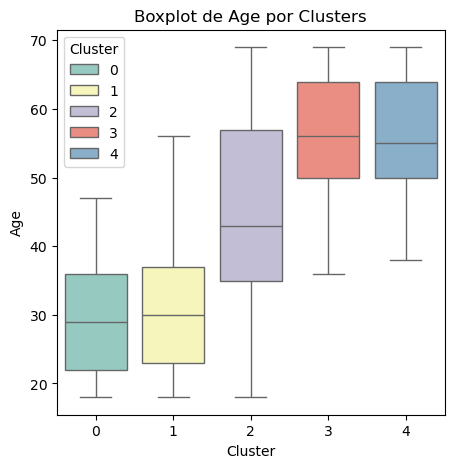

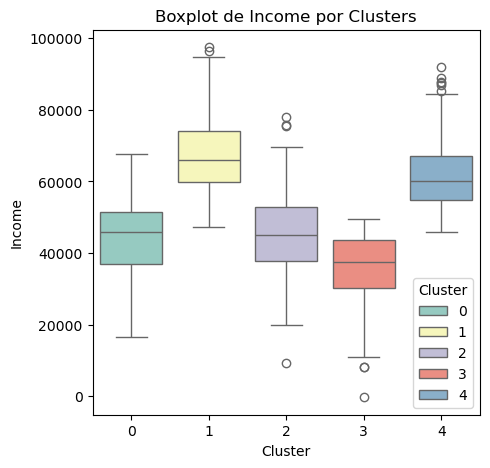

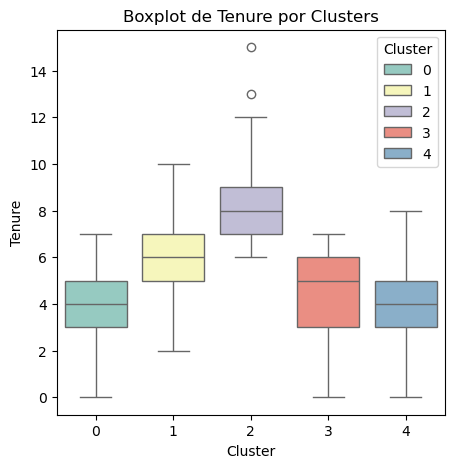

In [9]:
boxplot_clusters(numerical_features)

In [10]:
def barplot_clusters(columns):
    for col in columns:
        sns.countplot(x='Cluster', hue=col, data=data, palette='Set1')
        plt.title('Count of Entries by Geographic Location and Segmento')
        plt.xlabel('Geographic Location')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

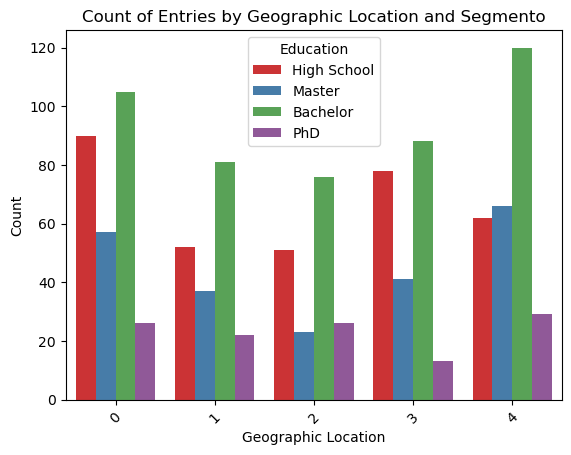

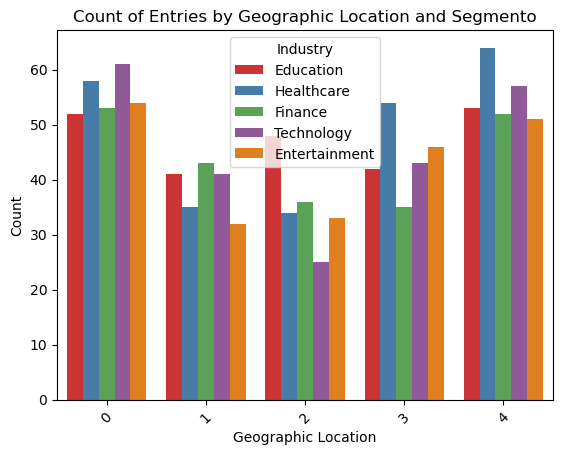

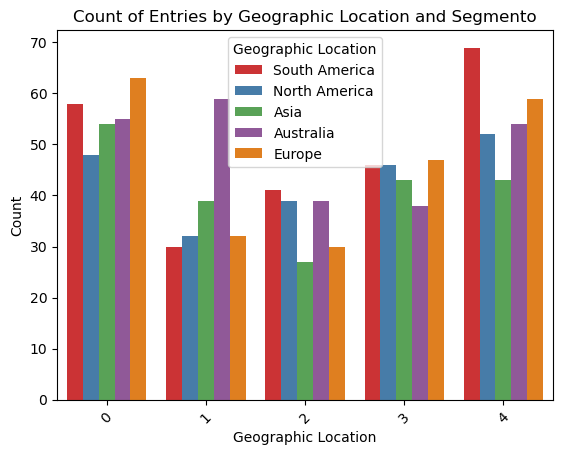

In [11]:
barplot_clusters(categorical_features)

In [12]:
def mean_clusters(columns):
    for col in columns:
        # Calcular la proporción de cada categoría dentro de cada Cluster
        data_grouped = data.groupby(['Cluster', col]).size().reset_index(name='Count')
        # Calcular la proporción
        data_grouped['Proportion'] = data_grouped['Count'] / data_grouped.groupby('Cluster')['Count'].transform('sum')

        plt.figure(figsize=(6, 4))
        sns.barplot(x='Cluster', y='Proportion', hue=col, data=data_grouped, palette='Set1')
        plt.title(f'Proportion of {col} by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel(f'Proportion of {col}')
        plt.xticks(rotation=45)
        plt.legend(title=col)
        plt.show()



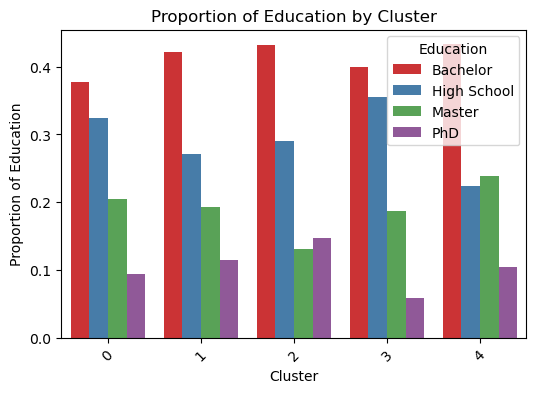

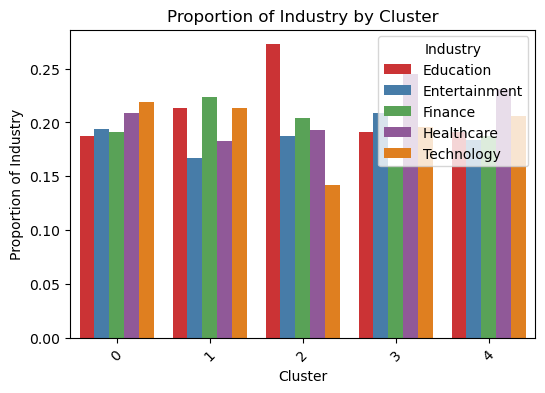

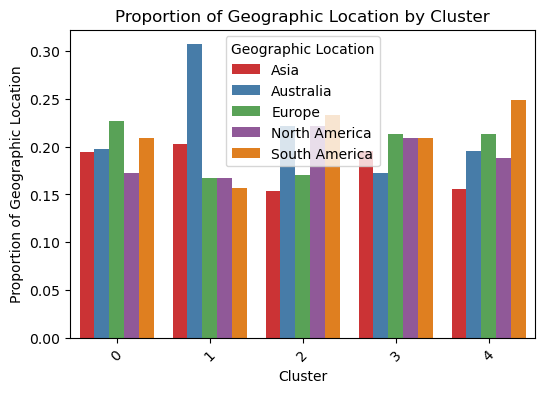

In [13]:
mean_clusters(categorical_features)